# LLM-as-a-judge

## Variable Definitions

In [1]:
import pandas as pd
import os
from tqdm import tqdm
tqdm.pandas()

from src.generate import load_llama, simple_call_llama
from src.data import files_to_df, read_document


N_EXPECTED_SAMPLES = 35

model_id = "/gpfs/projects/bsc14/abecerr1/hub/models--prometheus-eval--prometheus-7b-v2.0/snapshots/66ffb1fc20beebfb60a3964a957d9011723116c5"
source_path = "output/samples/en/phase_3/"
prompts_path = "utils/prompts"

path_gen = os.path.join(source_path, "generated")
path_orig = os.path.join(source_path, "original")
path_human = os.path.join(source_path, "human_eval.tsv")
path_auto = os.path.join(source_path, "auto_eval.tsv")

path_guidelines = os.path.join(prompts_path, "guidelines.txt")
guidelines = open(path_guidelines, "r").read()

assert os.path.exists(path_gen), f"Path {path_gen} does not exist"
assert os.path.exists(path_orig), f"Path {path_orig} does not exist"
assert os.path.exists(path_human), f"Path {path_human} does not exist"
assert os.path.exists(path_auto), f"Path {path_auto} does not exist"
assert os.path.exists(path_guidelines), f"Path {path_guidelines} does not exist"

## Load Data

### Clinical cases and Discharge summaries

35 Different pairs of clinical cases and discharge summaries are provided.

In the moment of writing this notebook, only 5 + 10 pairs have been annotated manually by one of our team members. The rest of the pairs are still pending to be annotated.

In [2]:
## Load and preprocess generated samples
df_pairs_gen = files_to_df(path_gen)
df_pairs_gen["filenameid"] = df_pairs_gen["filenameid"].str.replace("_transformed_step1", "")

## Load and preprocess original samples
df_pairs_orig = files_to_df(path_orig)

df_pairs = df_pairs_orig.merge(df_pairs_gen, on="filenameid", suffixes=("_orig", "_gen"))

# assert len(df_pairs) == N_EXPECTED_SAMPLES, f"Expected {N_EXPECTED_SAMPLES} samples, got {len(df_pairs)}"

df_pairs = df_pairs.rename(columns={"text_orig": "clinical_case", "text_gen": "discharge_summary"})
df_pairs.head()

,filenameid,clinical_case,discharge_summary
0,27198691,A 75-year-old man with permanent atrial fibril...,**Discharge Summary**\n\n**Patient Information...
1,29399767,A 54-year-old male had had a HeartMate 3™ impl...,**Discharge Summary**\n\n**Patient Information...
2,29877258,"A 35-year-old woman (gravida 1, para 1; uneven...",**Discharge Summary**\n\n**Patient Information...
3,29899452_1,The patient was a 29-year-old man with PIK3CA ...,**Discharge Summary**\n\n**Patient Information...
4,30170386,A 77-year-old man diagnosed with cutaneous sar...,**Discharge Summary**\n\n**Patient Information...


In [3]:
print(df_pairs.shape)

(30, 3)


### Human Evaluation

In [4]:
df_human = pd.read_csv(path_human, sep="\t")
df_human = df_human.rename(columns={"doc_id": "filenameid"})
# Extract only those belonging to Laura
df_human = df_human[df_human["annotator"] == "Laura"]
# d_score_cols = {
#                         "Overall validation [Content Relevance]": "Content Relevance",
#                         "Overall validation [Information Completeness]": "Information Completeness",
#                         "Overall validation [Clarity and Structure]": "Clarity and Structure",
#                         "Overall validation [Content Accuracy]": "Content Accuracy",
#                         "Overall validation [Hallucinations]": "Hallucinations",
#                         "Overall validation [Impact of Hallucinations]": "Impact of Hallucinations",
#                         "Overall validation [Relevance to Practice]": "Relevance to Practice",
#                         "Overall validation [Overall Quality]": "Overall Quality",
#                         "Positive highlights: Describe what aspects of the synthetic discharge summaries resemble the best real EHRs? (Empty if nothing remarkable)": "Positive highlights",
#                         "Negative highlights: Which aspects of the synthetic discharge summaries do not resemble well real EHRs? (Empty if nothing remarkable)": "Negative highlights",
#                         "Other Comments: Do you have any other feedback or comment on the generated synthetic discharge summaries or in the original cases? (Empty if nothing remarkable)": "Other Comments"
# }

# df_human.rename(columns=d_score_cols, inplace=True)
# df_human.rename(columns={"Original file name (e.g. 36951253)": "filenameid"}, inplace=True)

# columns_to_exclude = [
#     "Email Address", "Timestamp"
# ]
# df_human = df_human.drop(columns=columns_to_exclude)
# df_human = df_human.fillna("")

cols_score = ['Medical Entities Completeness', 'Structure - Headers',
                'Structure - Content', 'Content Accuracy', 'Made-up Content', 'Overall Quality', 'Feedback']
df_human_prompt = df_human[["filenameid"]].copy()
df_human_prompt["human_score"] = ""
df_human_prompt.loc[:, "human_score"] = df_human[cols_score].apply(lambda x: x.to_dict(), axis=1)

df_human_prompt.head()

,filenameid,human_score
0,27198691,"{'Medical Entities Completeness': 5, 'Structur..."
1,29399767,"{'Medical Entities Completeness': 5, 'Structur..."
2,29877258,"{'Medical Entities Completeness': 4, 'Structur..."
3,29899452_1,"{'Medical Entities Completeness': 4, 'Structur..."
4,30170386,"{'Medical Entities Completeness': 5, 'Structur..."


The amount of cases annotated by the human evaluators is 15 and they contain the following information:

- `filenameid`: The name of the file
- `human_score`: A dictionary with scores associated to
  - **Content Relevance**: Does the summary focus on clinically relevant information
  - **Information Completeness**: Does the summary include all key details (diagnoses, treatments, follow-ups)?
  - **Clarity and Structure**: Is the information presented in a clear and logically structured manner like a real discharge report?
  - **Content Accuracy**: Does the report accurately reflect the clinical information provided in the input?
  - **Hallucinations**: Are there any factual inaccuracies or fabricated content in the summary?
  - **Impact of Hallucinations**: How severe are these hallucination (e.g. 1-2: Irrelevant content, 3: include details about the patients not in original, 4-5: medication doses, procedures, etc)
  - **Relevance to Practice**: Would this summary be usable in clinical practice without significant revision?
  - **Overall Quality**: How would you rate the overall quality of the discharge summary?
  
  - Free text features to be commented in error analysis. Not mandatory but open to express as much or as few as wanted.
        - **Positive/Negative highlights of generation process**
        - **Other comments on Generated/Original data sources**

In [5]:
df_human_prompt["human_score"][0]

{'Medical Entities Completeness': 5,
 'Structure - Headers': 5,
 'Structure - Content': 5,
 'Content Accuracy': 5,
 'Made-up Content': 5,
 'Overall Quality': 5,
 'Feedback': 'The only thing I wanted to comment on is the diagnosis at the beginning of the DS. I think it would be more appropriate: Complications of the percutaneuos LAA oclusiob for permanent atrial fibrilation '}

In [6]:
print(df_human_prompt.shape)

(30, 2)


### Automatic Evaluation

Apart from human evaluation, we have also performed automatic evaluation about medical concepts coverage by applying named entity recognition (NER) and Entity Linking to UMLS to the clinical cases and discharge summaries.

The automatic evaluation is based on the following metrics:
- **precision**: The number of entities in the generated text that are correctly identified by the model divided by the total number of entities in the generated text.
- **recall**: The number of entities in the generated text that are correctly identified by the model divided by the total number of entities in the reference text.
- **f1**: The harmonic mean of precision and recall.

This automatic evaluation was performed over all the cases (1000 in total) and the results are stored in the `output/samples/en/phase_2/auto_eval.csv` file.

In [7]:
df_auto = pd.read_csv(path_auto, sep="\t")#.drop(columns=["cluster"])
# df_auto.rename(columns={"filename": "filenameid"}, inplace=True)
df_auto = df_auto[df_auto["filenameid"].isin(df_pairs["filenameid"])]
df_auto_prompt = df_auto[["filenameid"]].copy()
df_auto_prompt["auto_score"] = ""
df_auto_prompt.loc[:, "auto_score"] = df_auto.iloc[:, -3:].apply(lambda x: x.to_dict(), axis=1)

df_auto_prompt = df_auto_prompt.reset_index(drop=True)
df_auto_prompt.head()

,filenameid,auto_score
0,34946264,"{'precision': 0.8260869565217391, 'recall': 0...."
1,30971480_1,"{'precision': 0.6785714285714286, 'recall': 0...."
2,31377751,"{'precision': 0.71875, 'recall': 0.66666666666..."
3,30170386,"{'precision': 0.6666666666666666, 'recall': 0...."
4,30567249,"{'precision': 0.5555555555555556, 'recall': 0...."


In [8]:
print(df_auto_prompt.shape)

(30, 2)


### Combination

This dataset contains all the information about the clinical cases, discharge summaries, human evaluation and automatic evaluation.

**Caution**: As the filename id is one of the fields they have to introduce, it is possible that it's wrong. We hace to check it or modify the form making them select the file from a list.

In [9]:
# model = load_llama(model_id)
df_human_prompt["filenameid"] = df_human["filenameid"].astype(str)
# df_auto_prompt["filenameid"] = df_auto_prompt["filenameid"].astype(str)
df_pairs["filenameid"] = df_pairs["filenameid"].astype(str)

df_prompt = df_pairs.merge(df_human_prompt, on="filenameid").merge(df_auto_prompt, on="filenameid", how="inner")
df_prompt.head()

,filenameid,clinical_case,discharge_summary,human_score,auto_score
0,27198691,A 75-year-old man with permanent atrial fibril...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 5, 'Structur...","{'precision': 0.5384615384615384, 'recall': 0...."
1,29399767,A 54-year-old male had had a HeartMate 3™ impl...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 5, 'Structur...","{'precision': 0.5, 'recall': 0.333333333333333..."
2,29877258,"A 35-year-old woman (gravida 1, para 1; uneven...",**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 4, 'Structur...","{'precision': 0.3076923076923077, 'recall': 0...."
3,29899452_1,The patient was a 29-year-old man with PIK3CA ...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 4, 'Structur...","{'precision': 0.375, 'recall': 0.3636363636363..."
4,30170386,A 77-year-old man diagnosed with cutaneous sar...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 5, 'Structur...","{'precision': 0.6666666666666666, 'recall': 0...."


In [10]:
df_prompt.shape

(30, 5)

# Load Model

In [ ]:
from prometheus_eval.prompts import ABSOLUTE_PROMPT, SCORE_RUBRIC_TEMPLATE
from transformers import pipeline
import torch
# model_id = "/gpfs/projects/bsc14/abecerr1/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/0cb88a4f764b7a12671c53f0838cd831a0843b95"
model_id = "meta-llama/Llama-3.2-3B-Instruct"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    # device="cuda",
    device_map="auto",
)

terminators = [
    pipe.tokenizer.eos_token_id,
    pipe.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]


c:\Users\alber\Documents\GitHub\MultiSynDS\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

# Evaluate All Rubrics

## 1. Raw Evaluation

In [ ]:
# Likert scale evaluation rubric (ratings 1 to 5)

def generate_eval(pipe, rubric_data, instruction, response, reference_answer, template):

    rubric = SCORE_RUBRIC_TEMPLATE.format(**rubric_data)

    prompt = template.format(
        instruction=instruction,
        response=response,
        rubric=rubric,
        reference_answer=reference_answer,
    )

    # print(prompt)

    messages = [
        {
            "role": "system",
            "content": instruction
        },
        {
            "role": "user",
            "content": prompt
        }
    ]

    outputs = pipe(
                    messages,
                    max_new_tokens=256,
                    temperature=0.01,
                    # do_sample=True,
                    repetition_penalty=1.2,
                    eos_token_id=terminators,
                    pad_token_id=pipe.tokenizer.eos_token_id,
                )

    
    return outputs[0]["generated_text"][-1]["content"]


instruction = """
One of the main bottlenecks for the development of clinical NLP resources if the lack of access to clinical records due to data privacy issues. This is particularly true for developments beyond English, as most of the accessible anonymized clinical record datasets are only available for this language.
To examine if clinical case report publications could potentially be considered as a data source to generate synthetic clinical discharge summaries by means of generative AI solutions, prompt instructions combined with automatic clinical were applied.
This structured summary has the purpose to systematically characterize the clinical language characteristics of synthetic discharge summaries.
Each discharge summary was assessed for a predefined set of features.

The possible scores are 1, 2, 3, 4 and 5, where 1 is the lowest and 5 is the highest score. Try to be as objective as possible and provide a score that reflects the quality of the discharge summary.
"""

# Retrieve the generated discharge summary and the corresponding clinical case from the dataframe
response = df_prompt.iloc[13]["discharge_summary"]
reference_answer = df_prompt.iloc[13]["clinical_case"]

# Likert scale evaluation rubric (ratings 1 to 5)
rubric_data = {
    "Medical Entities Completeness": {
        "criteria": "Does the discharge summary (DS) include all medical entities (diseases, medications, procedures) originally in the CC? (Amount of entities in DS that are also in CC)",
        "score1_description": "<50% of relevant entities are included",
        "score2_description": "50% - 65% of relevant entities are included",
        "score3_description": "65% - 80% of relevant entities are included",
        "score4_description": "80% - 95% of relevant entities are included",
        "score5_description": "95% - 100% of relevant entities are included",
    },
    "Structure - Headers": {
        "criteria": "Does the discharge summary (DS) contain the typical sections? (e.g. patient information/history, physical examination, clinical findings, symptoms, signs, diagnostic assessment/diagnosis, therapeutic interventions/treatment, outcomes and follow up)",
        "score1_description": "Most of the important sections are missing",
        "score2_description": "At least 2 of the most important section headers are missing",
        "score3_description": "Section headers are correct but not in natural order",
        "score4_description": "The main section headers are included but some irrelevant ones have been included",
        "score5_description": "The section headers make sense and correspond to the ones expected in a real discharge summary"
    },
    "Structure - Content": {
        "criteria": "Is the content in the discharge summary sections correct?",
        "score1_description": "Sections are very short or almost empty",
        "score2_description": "At least 2 section headers don't correspond to the expected content for that header",
        "score3_description": "At least 1 section header doesn't correspond to the expected content for that header",
        "score4_description": "Information is well structured but information is too short in at least 1 case",
        "score5_description": "Information is correctly assigned to each section"
    },
    "Content Accuracy": {
        "criteria": "Does the discharge summary (DS) accurately reflect the clinical entities (findings, diseases, signs and symptoms) provided in the clinical case report (CC)?",
        "score1_description": "Overall, the content in DS is more concrete than in the CC",
        "score2_description": "Overall, the content in DS is more general than in the CC",
        "score3_description": "There are 2 or more clinical entities that are not completely accurate",
        "score4_description": "There are 1 or more clinical entities that are not completely accurate",
        "score5_description": "All the clinical entities are accurate"
    },
    "Made-up Content": {
        "criteria": "Does the discharge summary (DS) include additional patient's medical situation information not described in the clinical case (CC)? (Fabricated content)",
        "score1_description": "It made up 2 or more medicament dosage or disease severity",
        "score2_description": "It made up 1 or more medicament dosage or disease severity",
        "score3_description": "It made up information about the patient",
        "score4_description": "It made up irrelevant information",
        "score5_description": "It didn't make anything up"
    },
    "Overall Quality": {
        "criteria": "How would you rate the overall quality of the summary?",
        "score1_description": "It completely failed all the assessments",
        "score2_description": "Failed 3 of the previous aspects",
        "score3_description": "Failed 2 of the previous aspects",
        "score4_description": "Failed 1 of the previous aspects",
        "score5_description": "It is complete, well structured, accurate and without made‑up content"
    }
}


abs_template = """
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: "{{'feedback': <feedback>, 'score': <number from 1 to 5>}}".
4. Please do not generate any other opening, closing, and explanations.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
{rubric}

###Feedback: 
"""

df_gen = df_prompt.copy()
ls_dict = []

for key, value in tqdm(rubric_data.items()):
    df_gen[key] = df_gen.progress_apply(
        lambda x: generate_eval(
            pipe,
            rubric_data[key],
            instruction,
            x["discharge_summary"],
            x["clinical_case"],
            abs_template
        ),
        axis=1
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:02<00:00, 50.44s/it]


In [ ]:
df_gen.to_csv("tmp/interm_llama_df_gen.tsv", sep="\t", index=False)

## 2. Process Outputs

In [ ]:
df_gen

,filenameid,clinical_case,discharge_summary,human_score,auto_score,Medical Entities Completeness,Structure - Headers,Structure - Content,Content Accuracy,Made-up Content,Overall Quality
0,31668014,A 67‐year‐old man treated with hemodialysis wa...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 4, 'Structur...","{'precision': 0.6551724137931034, 'recall': 0....",{'feedback': 'The provided discharge summary i...,{'feedback': 'The discharge summary contains a...,{'feedback': 'Content in Discharge Summary Sec...,"{'feedback': 'Overall, the content in the disc...",{'feedback': 'The provided discharge summary i...,{'feedback': 'The response provides clear pati...
1,32864940,"GSA, male, 55 years old, white, forklift opera...",**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 3, 'Structur...","{'precision': 0.5714285714285714, 'recall': 0....",{'feedback': 'The provided discharge summary i...,{'feedback': 'The response contains all the ty...,{'feedback': 'The provided discharge summary a...,"{'feedback': 'Overall, the structure and organ...",{'feedback': 'The provided discharge summary i...,{'feedback': 'The provided discharge summary i...
2,35414581,Patient information\nA woman in her 70s diagno...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 4, 'Structur...","{'precision': 0.5384615384615384, 'recall': 0....",{'feedback': 'The response provides a clear st...,{'feedback': 'The response contains all necess...,{'feedback': 'The response provides clear deta...,{'feedback': 'The response provides a clear st...,{'feedback': 'The response provides a clear st...,{'feedback': 'The response provides clear deta...
3,29399767,A 54-year-old male had had a HeartMate 3™ impl...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 5, 'Structur...","{'precision': 0.5, 'recall': 0.333333333333333...",{'feedback': 'The response provides a comprehe...,{'feedback': 'The response contains all necess...,{'feedback': 'The response provides accurate d...,"{'feedback': 'Overall, the content in your dis...",{'feedback': 'The response provides a clear de...,{'feedback': 'The response provides clear info...
4,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 2, 'Structur...","{'precision': 0.6, 'recall': 0.466666666666666...",{'feedback': 'The provided discharge summary e...,{'feedback': 'The provided discharge summary c...,{'feedback': 'The provided discharge summary a...,{'feedback': 'The discharge summary provides s...,{'feedback': 'The provided discharge summary e...,{'feedback': 'The provided discharge summary e...
5,33544806,Clinical history\n\nFour years before the admi...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 2, 'Structur...","{'precision': 0.2, 'recall': 0.333333333333333...",{'feedback': 'The provided discharge summary i...,{'feedback': 'The DS contains the typical sect...,{'feedback': 'Information is well structured a...,"{'feedback': 'Overall, the content in the disc...",{'feedback': 'The provided discharge summary i...,{'feedback': 'The response provides a comprehe...
6,29899452_1,The patient was a 29-year-old man with PIK3CA ...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 4, 'Structur...","{'precision': 0.59375, 'recall': 0.57575757575...",{'feedback': 'The provided discharge summary i...,{'feedback': 'The discharge summary includes a...,{'feedback': 'The provided discharge summary i...,"{'feedback': 'Overall, the content in the disc...",{'feedback': 'The provided discharge summary i...,{'feedback': 'The response provides comprehens...
7,32305569,Our case patient is a 66-year-old man with a h...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 4, 'Structur...","{'precision': 0.4888888888888

In [ ]:
df_gen["Medical Entities Completeness"].values

array(["{'feedback': 'The provided discharge summary includes almost all necessary information regarding patient history, current condition, diagnosis, treatments, and medication lists. However, some minor details such as specific dosages of certain medications might have been omitted. Additionally, while the structure appears clear, the narrative sometimes jumps abruptly between different topics, which may make reading more challenging than necessary.', \n'score': 4}",
       "{'feedback': 'The provided discharge summary includes most of the original information present in the Case Control (CC) while maintaining clarity and coherence. However, some minor discrepancies exist regarding specific details such as medication names and dosages, possibly indicating variations in clinical practice or transcription errors.', \n'score': 4}",
       "{'feedback': 'The response provides a clear structure for assessing the quality of a discharge summary, including key elements like patient informat

In [ ]:
example = '{"feedback": The provided discharge summary includes all necessary sections such as Patient Information/History, Admission Date, Discharge Date, Attending Physician, Diagnosis, Procedure, Post-Procedural Findings, Follow-Up, Rehospitalization, Outcome, Recommendations, Prepared By, and Date. However, the formatting might seem somewhat unnatural or artificial because the structure does not exactly mirror how these elements would typically appear together within a standard clinical setting. Furthermore, while each required element exists, certain details like specific medication names used during treatment may be lacking which can sometimes occur when using automated systems."\n\n"score": 4 }'
import ast


feedback = re.split(r"[\"\']score[\"\']:", example)[0].split(":")[1]
scores = re.split(r"[\"\']score[\"\']:", example)[1][:-1].strip()
scores

'4'

In [ ]:
import re
import json
def safe_json_extract(text):
    text = text.replace('Feedback', 'feedback"')
    match = re.search(r"\{[^{}]*[\"\']feedback[\"\'][^{}]*[\"\']score[\"\']\s*:\s*\d[^{}]*\}", text)
    # print(f"Match: {match}")
    # print(match.group(0).replace("\"", ""))
    
    if match:
        try:
            d_out = ast.literal_eval(match.group(0))
            return d_out
        except:
            text_out = match.group(0)
            text_out = text_out.replace(" \n'score'", "'score'")
            text_out = text_out.replace("\n", "")
            try:
                feedback = re.split(r"[\"\']score[\"\']:", text_out)[0].split(":")[1].strip()
                scores = re.split(r"[\"\']score[\"\']:", example)[1][:-1].strip()
                # print(f"Feedback: {feedback}")
                # print(f"Score: {scores}")
                d_out = {
                    "feedback": feedback,
                    "score": int(scores)
                }
                return d_out
            except Exception as e:
                print(f"Error: {e}")
                print(f"Text: {text_out}")

                # print(re.split(r"[\"\']score[\"\']:", text_out)[0].split(":")[1])
                # print(len(re.split(r"[\"\']score[\"\']:", text_out)))
                # print()
                return None
    else:
        print(f"Regex failed to match: {text}")
    

for key, value in tqdm(rubric_data.items()):
    df_gen["dict_" + key] = df_gen[key].apply(safe_json_extract)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1229.22it/s]


In [ ]:
df_gen

,filenameid,clinical_case,discharge_summary,human_score,auto_score,Medical Entities Completeness,Structure - Headers,Structure - Content,Content Accuracy,Made-up Content,Overall Quality,dict_Medical Entities Completeness,dict_Structure - Headers,dict_Structure - Content,dict_Content Accuracy,dict_Made-up Content,dict_Overall Quality
0,31668014,A 67‐year‐old man treated with hemodialysis wa...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 4, 'Structur...","{'precision': 0.6551724137931034, 'recall': 0....",{'feedback': 'The provided discharge summary i...,{'feedback': 'The discharge summary contains a...,{'feedback': 'Content in Discharge Summary Sec...,"{'feedback': 'Overall, the content in the disc...",{'feedback': 'The provided discharge summary i...,{'feedback': 'The response provides clear pati...,{'feedback': 'The provided discharge summary i...,{'feedback': 'The discharge summary contains a...,{'feedback': 'Content in Discharge Summary Sec...,"{'feedback': 'Overall, the content in the disc...",{'feedback': 'The provided discharge summary i...,{'feedback': 'The response provides clear pati...
1,32864940,"GSA, male, 55 years old, white, forklift opera...",**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 3, 'Structur...","{'precision': 0.5714285714285714, 'recall': 0....",{'feedback': 'The provided discharge summary i...,{'feedback': 'The response contains all the ty...,{'feedback': 'The provided discharge summary a...,"{'feedback': 'Overall, the structure and organ...",{'feedback': 'The provided discharge summary i...,{'feedback': 'The provided discharge summary i...,{'feedback': 'The provided discharge summary i...,{'feedback': 'The response contains all the ty...,{'feedback': 'The provided discharge summary a...,"{'feedback': 'Overall, the structure and organ...",{'feedback': 'The provided discharge summary i...,{'feedback': 'The provided discharge summary i...
2,35414581,Patient information\nA woman in her 70s diagno...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 4, 'Structur...","{'precision': 0.5384615384615384, 'recall': 0....",{'feedback': 'The response provides a clear st...,{'feedback': 'The response contains all necess...,{'feedback': 'The response provides clear deta...,{'feedback': 'The response provides a clear st...,{'feedback': 'The response provides a clear st...,{'feedback': 'The response provides clear deta...,{'feedback': 'The response provides a clear st...,{'feedback': 'The response contains all necess...,{'feedback': 'The response provides clear deta...,{'feedback': 'The response provides a clear st...,{'feedback': 'The response provides a clear st...,{'feedback': 'The response provides clear deta...
3,29399767,A 54-year-old male had had a HeartMate 3™ impl...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 5, 'Structur...","{'precision': 0.5, 'recall': 0.333333333333333...",{'feedback': 'The response provides a comprehe...,{'feedback': 'The response contains all necess...,{'feedback': 'The response provides accurate d...,"{'feedback': 'Overall, the content in your dis...",{'feedback': 'The response provides a clear de...,{'feedback': 'The response provides clear info...,{'feedback': 'The response provides a comprehe...,{'feedback': 'The response contains all necess...,{'feedback': 'The response provides accurate d...,"{'feedback': 'Overall, the content in your dis...",{'feedback': 'The response provides a clear de...,{'feedback': 'The response provides clear info...
4,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 2, 'Structur...","{'precision': 0.6, 'recall': 0.466666666666666...",{'feedback': 'The provided discharge summary e...,{'feedback': 'The provided discharge summary c...,{'feedback': 'The provided discharge summary a...,{'feedback': 'The discha

In [ ]:
ls_feedbacks = []
ls_scores = []
for idx, row in df_gen.iterrows():
    d_scores = {}
    d_feedbacks = {}
    for key, value in rubric_data.items():
        # if isinstance(row["dict_" + key], dict):
        try:
            feedback = row["dict_" + key]["feedback"]
            # print(feedback)
            score = row["dict_" + key]["score"]
            # print(score)
        except KeyError as e:
            print(f"Error", {e})
            print(feedback)
            print(score)

        # else:
        #     feedback = row["dict_" + key]
        #     score = None
        
        d_scores[key] = score
        d_feedbacks[key] = feedback
    
    ls_scores.append(d_scores)
    ls_feedbacks.append(d_feedbacks)
        
ls_scores

[{'Medical Entities Completeness': 4,
  'Structure - Headers': 4,
  'Structure - Content': 5,
  'Content Accuracy': 5,
  'Made-up Content': 4,
  'Overall Quality': 4},
 {'Medical Entities Completeness': 4,
  'Structure - Headers': 5,
  'Structure - Content': 5,
  'Content Accuracy': 4,
  'Made-up Content': 4,
  'Overall Quality': 4},
 {'Medical Entities Completeness': 4,
  'Structure - Headers': 5,
  'Structure - Content': 4,
  'Content Accuracy': 5,
  'Made-up Content': 4,
  'Overall Quality': 4},
 {'Medical Entities Completeness': 4,
  'Structure - Headers': 5,
  'Structure - Content': 5,
  'Content Accuracy': 5,
  'Made-up Content': 4,
  'Overall Quality': 4},
 {'Medical Entities Completeness': 5,
  'Structure - Headers': 5,
  'Structure - Content': 5,
  'Content Accuracy': 4,
  'Made-up Content': 4,
  'Overall Quality': 4},
 {'Medical Entities Completeness': 5,
  'Structure - Headers': 4,
  'Structure - Content': 5,
  'Content Accuracy': 5,
  'Made-up Content': 4,
  'Overall Qualit

In [ ]:
example = df_gen["dict_Medical Entities Completeness"][0]
print(example)

{'feedback': 'The provided discharge summary includes almost all necessary information regarding patient history, current condition, diagnosis, treatments, and medication lists. However, some minor details such as specific dosages of certain medications might have been omitted. Additionally, while the structure appears clear, the narrative sometimes jumps abruptly between different topics, which may make reading more challenging than necessary.', 'score': 4}


In [ ]:
df_prompt_out = df_prompt.copy()
df_prompt_out["feedbacks"] = ls_feedbacks
df_prompt_out["scores"] = ls_scores

df_prompt_out


,filenameid,clinical_case,discharge_summary,human_score,auto_score,feedbacks,scores
0,31668014,A 67‐year‐old man treated with hemodialysis wa...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 4, 'Structur...","{'precision': 0.6551724137931034, 'recall': 0....",{'Medical Entities Completeness': 'The provide...,"{'Medical Entities Completeness': 4, 'Structur..."
1,32864940,"GSA, male, 55 years old, white, forklift opera...",**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 3, 'Structur...","{'precision': 0.5714285714285714, 'recall': 0....",{'Medical Entities Completeness': 'The provide...,"{'Medical Entities Completeness': 4, 'Structur..."
2,35414581,Patient information\nA woman in her 70s diagno...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 4, 'Structur...","{'precision': 0.5384615384615384, 'recall': 0....",{'Medical Entities Completeness': 'The respons...,"{'Medical Entities Completeness': 4, 'Structur..."
3,29399767,A 54-year-old male had had a HeartMate 3™ impl...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 5, 'Structur...","{'precision': 0.5, 'recall': 0.333333333333333...",{'Medical Entities Completeness': 'The respons...,"{'Medical Entities Completeness': 4, 'Structur..."
4,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 2, 'Structur...","{'precision': 0.6, 'recall': 0.466666666666666...",{'Medical Entities Completeness': 'The provide...,"{'Medical Entities Completeness': 5, 'Structur..."
5,33544806,Clinical history\n\nFour years before the admi...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 2, 'Structur...","{'precision': 0.2, 'recall': 0.333333333333333...",{'Medical Entities Completeness': 'The provide...,"{'Medical Entities Completeness': 5, 'Structur..."
6,29899452_1,The patient was a 29-year-old man with PIK3CA ...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 4, 'Structur...","{'precision': 0.59375, 'recall': 0.57575757575...",{'Medical Entities Completeness': 'The provide...,"{'Medical Entities Completeness': 5, 'Structur..."
7,32305569,Our case patient is a 66-year-old man with a h...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 4, 'Structur...","{'precision': 0.4888888888888889, 'recall': 0....",{'Medical Entities Completeness': 'The provide...,"{'Medical Entities Completeness': 4, 'Structur..."
8,32351016_1,A 73‐year‐old female patient was hospitalized ...,**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 4, 'Structur...","{'precision': 0.48, 'recall': 0.36363636363636...",{'Medical Entities Completeness': 'The provide...,"{'Medical Entities Completeness': 4, 'Structur..."
9,33782774,"A 20-year-old man (height: 138 cm, weight: 39 ...",**Discharge Summary**\n\n**Patient Information...,"{'Medical Entities Completeness': 2, 'Structur...","{'precision': 0.5757575757575758, 'recall': 0....",{'Medical Entities Completeness': 'The provide...,"{'Medical Entities Completeness': 5, 'Structur..."


In [ ]:
# Save the results
df_prompt_out.to_csv("output/samples/en/phase_3/llama_3B_inst_std_prompt_evaluation.tsv", index=False, sep="\t")

In [ ]:
df_prompt_out.head()

,filenameid,clinical_case,discharge_summary,human_score,auto_score,feedbacks,scores
0,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.8666666088888928, 'recall': 0....",{'Medical Entities Completeness': 'The provide...,"{'Medical Entities Completeness': 4, 'Structur..."
1,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.3333333055555579, 'recall': 0....",{'Medical Entities Completeness': 'The DS incl...,"{'Medical Entities Completeness': 4, 'Structur..."
2,30072860_2,A 72-year-old man with a history of hypertensi...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.6666666222222252, 'recall': 0....",{'Medical Entities Completeness': 'The provide...,"{'Medical Entities Completeness': 4, 'Structur..."
3,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.9189188940832732, 'recall': 0....",{'Medical Entities Completeness': 'The provide...,"{'Medical Entities Completeness': 4, 'Structur..."
4,31486515,A 57-year-old Caucasian man was admitted to th...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.8275861783590973, 'recall': 0....",{'Medical Entities Completeness': 'The provide...,"{'Medical Entities Completeness': 4, 'Structur..."


# Result Analysis

**Important**: This is some extra analysis. The good one is in `nbs/generative/analysis.ipynb` notebook.

In [ ]:
df_jud = pd.DataFrame(df_prompt_out["scores"].values.tolist())
# FIll NaN values with mode
for col in df_jud.columns:
    df_jud[col] = df_jud[col].fillna(df_jud[col].mode()[0])
df_jud = df_jud.astype(int)
# df_jud.columns = [f"{col}_judge" for col in df_jud.columns]
df_jud

,Medical Entities Completeness,Structure - Headers,Structure - Content,Content Accuracy,Made‑up Content,Overall Quality
0,4,5,5,4,4,5
1,4,5,5,4,4,4
2,4,5,5,5,5,5
3,4,5,5,4,4,4
4,4,5,5,5,5,5
5,5,5,5,5,4,5
6,5,5,5,5,4,5
7,4,5,5,4,4,4
8,4,5,5,5,5,4
9,4,5,5,4,4,4


In [ ]:
df_human_ = pd.DataFrame(df_prompt_out["human_score"].values.tolist())
df_human_

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights,Negative highlights,Other Comments
0,4,4,4,5,1,1,5,4,,"falta información sobre tipo de prótesis, ause...",
1,4,3,4,4,1,1,4,4,,Se pierde mucha información sobre la explicaci...,
2,4,3,4,3,1,1,3,3,ordena muy bien los resultados de la ecografía.,Faltan los datos hemodinámicos cardiacos y pul...,
3,5,5,3,5,1,1,3,4,"datos muy completos, estrcutura fiel al docume...",La parte correspondiente a la enfermedad actu...,
4,5,5,4,4,1,1,4,4,,Se debería mencionar el motivo de admisión: an...,
5,5,5,4,4,1,1,4,4,Muy bien especificado Chief complaint,Se podría separar la enfermedad actual de los ...,
6,4,2,5,4,1,1,2,3,Very well structured and explained. Abbrevatio...,"The text has been oversummarized, leaving out ...",
7,5,5,4,5,1,1,5,5,,la razón de admisión suele ser algo más genera...,
8,5,4,5,5,1,1,5,5,,,
9,5,5,5,5,1,1,5,5,,,


In [ ]:
df_human_.loc[10]["Positive highlights"]

'Highly accurate in the diagnosis.An excellent overall performance'

In [ ]:
df_human_.loc[10]["Negative highlights"]

'Omited information: ECG Holter and EKG after CV (both are important in FA clinical cases)'

In [ ]:
import numpy as np
{col: np.corrcoef(df_jud[col], df_human_[col])[0, 1] for col in df_jud.columns}

KeyError: 'Medical Entities Completeness'

In [ ]:
df_human_["filenameid"] = df_prompt_out["filenameid"]
df_jud["filenameid"] = df_prompt_out["filenameid"]

In [ ]:
merged = df_human_.merge(df_jud, on="filenameid", how="inner", suffixes=("_human", "_judge"))
merged_int = merged.select_dtypes(include=[np.int64, np.float64])
merged_int.corr(method="pearson")

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy_human,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality_human,Medical Entities Completeness,Structure - Headers,Structure - Content,Content Accuracy_judge,Made‑up Content,Overall Quality_judge
Content Relevance,1.000000,8.978044e-01,0.551825,0.855902,NaN,NaN,0.825009,8.519509e-01,8.311716e-02,1.781453e-01,0.027206,1.799539e-01,-0.006802,0.401296
Information Completeness,0.897804,1.000000e+00,0.335364,0.822602,NaN,NaN,0.829545,8.758113e-01,1.026365e-16,2.712550e-16,0.318529,3.370999e-02,-0.222971,0.159265
Clarity and Structure,0.551825,3.353638e-01,1.000000,0.534865,NaN,NaN,0.572091,5.405899e-01,-2.027212e-01,2.896621e-01,-0.287543,4.681646e-01,0.154831,0.486611
Content Accuracy_human,0.855902,8.226015e-01,0.534865,1.000000,NaN,NaN,0.867471,9.093600e-01,-7.684733e-02,1.882367e-01,0.016769,-8.873565e-02,-0.192849,0.058693
Hallucinations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Impact of Hallucinations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relevance to Practice,0.825009,8.295455e-01,0.572091,0.867471,NaN,NaN,1.000000,9.244675e-01,-1.946247e-01,1.191828e-01,0.318529,3.370999e-02,-0.127412,0.159265
Overall Quality_human,0.851951,8.758113e-01,0.540590,0.909360,NaN,NaN,0.924467,1.000000e+00,-1.666667e-01,6.804138e-02,0.218218,4.807407e-17,-0.190941,0.081832
Medical Entities Completeness,0.083117,1.026365e-16,-0.202721,-0.076847,NaN,NaN,-0.194625,-1.666667e-01,1.000000e+00,-6.804138e-02,-0.218218,1.682592e-16,0.327327,0.327327
Structure - Headers,0.178145,2.712550e-16,0.289662,0.188237,NaN,NaN,0.119183,6.804138e-02,-6.804138e-02,1.000000e+00,-0.133631,3.535534e-01,-0.133631,0.200446


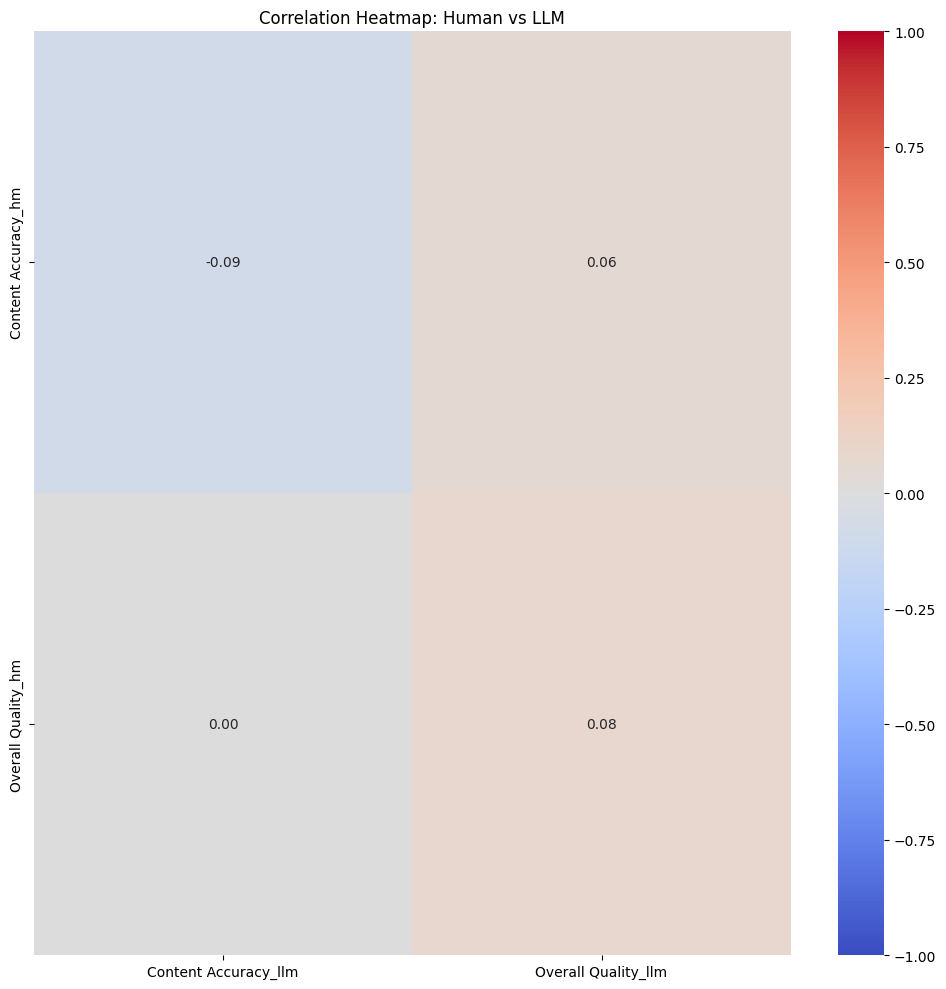

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_correlation_heatmap(df_hm, df_llm, suffixes=("_hm", "_llm")):
    """Plot a heatmap of correlations."""
    
    df_hm_llm_corr = df_hm.merge(df_llm, on="filenameid", suffixes=suffixes)
    df_hm_llm_corr = df_hm_llm_corr.select_dtypes(include=[np.int64, np.float64]).corr().fillna(0)
    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    x_suffix, y_suffix = suffixes[0], suffixes[1]
    x_cols = [col for col in df_hm_llm_corr.columns if col.endswith(x_suffix)]
    y_cols = [col for col in df_hm_llm_corr.columns if col.endswith(y_suffix)]

    corr_matrix = df_hm_llm_corr.loc[x_cols, y_cols]
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1, ax=ax)
    ax.set_title("Correlation Heatmap: Human vs LLM")
    fig.tight_layout()
    # plt.savefig(os.path.join(output_path, "correlation_heatmap.png"))   
    return fig , corr_matrix

fig, corr_matrix = plot_correlation_heatmap(df_human_, df_jud)

# plt.savefig("output/evaluation/Form2/phase_2/llama_3B_inst_std_prompt/correlation_heatmap.png")

In [ ]:
def get_corr_scores(df_human, df_jud):
    """Compute the correlation scores."""
    
    corr_scores = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        corr_scores[col] = np.corrcoef(df_human[col], df_jud[col])[0, 1]
    return corr_scores

corr_scores = get_corr_scores(df_human_, df_jud)
corr_scores

/home/bsc/bsc830651/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bsc/bsc830651/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


{'Content Relevance': nan,
 'Information Completeness': 0.7479575920067657,
 'Clarity and Structure': 0.13514747567989727,
 'Content Accuracy': -0.28235511231217136,
 'Hallucinations': nan,
 'Impact of Hallucinations': nan,
 'Relevance to Practice': 0.3901173649577245,
 'Overall Quality': 0.054554472558998035}

In [ ]:
def get_mae_scores(df_human, df_jud):
    """Compute the mean absolute error scores."""
    
    mae_scores = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        mae_scores[col] = np.mean(np.abs(df_human[col] - df_jud[col]))
    return mae_scores

mae_scores = get_mae_scores(df_human_, df_jud)
mae_scores

{'Content Relevance': 0.8666666666666667,
 'Information Completeness': 1.2,
 'Clarity and Structure': 0.6,
 'Content Accuracy': 1.0,
 'Hallucinations': 3.4,
 'Impact of Hallucinations': 3.533333333333333,
 'Relevance to Practice': 1.2,
 'Overall Quality': 0.9333333333333333}

In [ ]:
from sklearn.metrics import f1_score
def get_f1_scores(df_human, df_jud):
    """Compute the F1 scores."""
    
    f1_scores = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        f1_scores[col] = f1_score(df_human[col], df_jud[col], average="weighted")
    return f1_scores

f1_scores = get_f1_scores(df_human_, df_jud)
f1_scores

{'Content Relevance': 0.3710144927536232,
 'Information Completeness': 0.25263157894736843,
 'Clarity and Structure': 0.4952380952380952,
 'Content Accuracy': 0.3218045112781954,
 'Hallucinations': 0.0,
 'Impact of Hallucinations': 0.0,
 'Relevance to Practice': 0.2571428571428572,
 'Overall Quality': 0.3255411255411255}

In [ ]:
df_eval = pd.DataFrame([corr_scores, mae_scores, f1_scores]).T
df_eval.columns = ["correlation", "mae", "f1"]
df_eval

,correlation,mae,f1
Content Relevance,NaN,0.866667,0.371014
Information Completeness,0.747958,1.200000,0.252632
Clarity and Structure,0.135147,0.600000,0.495238
Content Accuracy,-0.282355,1.000000,0.321805
Hallucinations,NaN,3.400000,0.000000
Impact of Hallucinations,NaN,3.533333,0.000000
Relevance to Practice,0.390117,1.200000,0.257143
Overall Quality,0.054554,0.933333,0.325541


In [ ]:
# df_eval.to_csv("output/evaluation/Form2/phase_2/Form2/phase_2/Form2/phase_2/llama_3B_inst_std_prompt/evaluation_scores.csv")

In [ ]:
df_diff = (df_jud.select_dtypes(int) - df_human_.select_dtypes(int))
df_diff["filenameid"] = df_jud["filenameid"]

df_diff.select_dtypes(int).abs().mean()

Content Relevance           0.866667
Information Completeness    1.200000
Clarity and Structure       0.600000
Content Accuracy            1.000000
Hallucinations              3.400000
Impact of Hallucinations    3.533333
Relevance to Practice       1.200000
Overall Quality             0.933333
dtype: float64

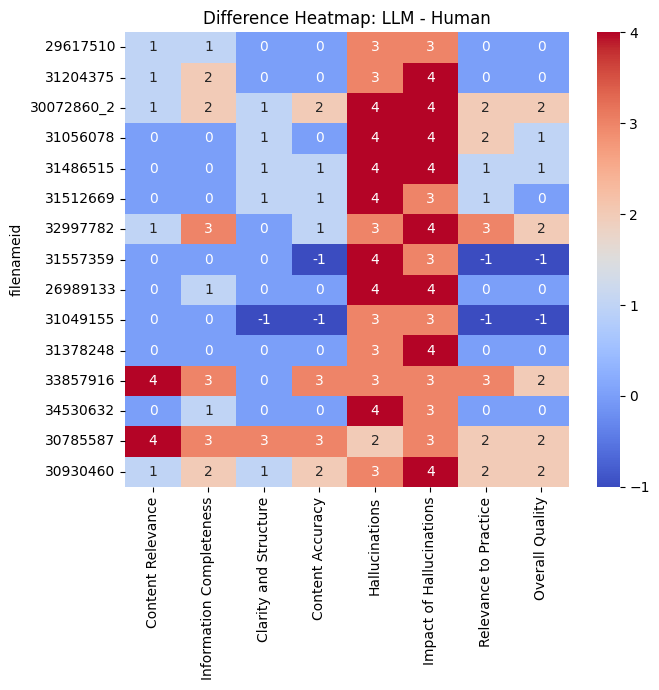

In [ ]:
import seaborn as sns

plt.figure(figsize=(7, 7))
sns.heatmap(df_diff.set_index("filenameid"), annot=True, cmap="coolwarm")
plt.title("Difference Heatmap: LLM - Human")
plt.tight_layout()
plt.savefig("output/evaluation/Form2/phase_2/Form2/phase_2/Form2/phase_2/prometheus-2-7B/difference_heatmap.png")

In [ ]:
col = "Information Completeness"
y_true = df_human_[col]
y_pred = df_jud[col]

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.46      1.00      0.63         6

    accuracy                           0.40        15
   macro avg       0.09      0.20      0.13        15
weighted avg       0.18      0.40      0.25        15



In [ ]:
df_jud

,Medical Entities Completeness,Structure - Headers,Structure - Content,Content Accuracy,Made‑up Content,Overall Quality,filenameid
0,4,5,5,4,4,4,29617510
1,5,5,5,4,4,4,31204375
2,4,5,5,5,5,5,30072860_2
3,5,5,5,4,4,4,31056078
4,5,4,5,5,5,5,31486515
5,5,5,5,5,4,5,31512669
6,5,5,4,5,5,5,32997782
7,4,5,5,5,4,4,31557359
8,4,5,5,5,5,5,26989133
9,4,4,5,4,4,4,31049155


In [ ]:
df_human_

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights,Negative highlights,Other Comments,filenameid
0,4,4,4,5,1,1,5,4,,"falta información sobre tipo de prótesis, ause...",,29617510
1,4,3,4,4,1,1,4,4,,Se pierde mucha información sobre la explicaci...,,31204375
2,4,3,4,3,1,1,3,3,ordena muy bien los resultados de la ecografía.,Faltan los datos hemodinámicos cardiacos y pul...,,30072860_2
3,5,5,3,5,1,1,3,4,"datos muy completos, estrcutura fiel al docume...",La parte correspondiente a la enfermedad actu...,,31056078
4,5,5,4,4,1,1,4,4,,Se debería mencionar el motivo de admisión: an...,,31486515
5,5,5,4,4,1,1,4,4,Muy bien especificado Chief complaint,Se podría separar la enfermedad actual de los ...,,31512669
6,4,2,5,4,1,1,2,3,Very well structured and explained. Abbrevatio...,"The text has been oversummarized, leaving out ...",,32997782
7,5,5,4,5,1,1,5,5,,la razón de admisión suele ser algo más genera...,,31557359
8,5,4,5,5,1,1,5,5,,,,26989133
9,5,5,5,5,1,1,5,5,,,,31049155


In [ ]:
col = "Overall Quality"
y_true = df_human_[col]
y_pred = df_jud[col]

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.50      0.67      0.57         6
           5       0.29      0.50      0.36         4

    accuracy                           0.40        15
   macro avg       0.20      0.29      0.23        15
weighted avg       0.28      0.40      0.33        15



In [ ]:
df_qual_eval = df_prompt.copy()
df_qual_eval.set_index("filenameid", inplace=True)
df_fb = df_qual_eval["feedbacks"].apply(pd.Series)
print(df_fb.loc["33857916"].to_markdown())

|                          | 33857916                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
print(df_human_[df_human_["filenameid"] == "33857916"].T.to_markdown())

|                          | 11                                                                                                                                                        |
|:-------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------|
| Content Relevance        | 1                                                                                                                                                         |
| Information Completeness | 1                                                                                                                                                         |
| Clarity and Structure    | 4                                                                                                                                                         |
| Content Accuracy         | 2                                             